
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    # Masking actions_logits unmasked
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_real and nextQs_fake
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                hidden_size=hidden_size)
    nextQs_real = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                hidden_size=hidden_size, reuse=True)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_fake2 + g_loss_real

    # Discriminator loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                         labels=tf.zeros_like(nextQs)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.nn.sigmoid(nextQs)))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [10]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [14]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 4 Training g_loss: 2.0405 Training d_loss: 1.3442 Explore P: 0.9996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 15 Training g_loss: 1.9391 Training d_loss: 1.2740 Explore P: 0.9981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 21 Training g_loss: 1.9125 Training d_loss: 1.2356 Explore P: 0.9960
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 45 Training g_loss: 1.9096 Training d_loss: 1.2264 Explore P: 0.9916
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 34 Total reward: 51 Training g_loss: 1.8392 Training d_loss: 1.1492 Explore P: 0.9282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 47 Training g_loss: 1.8100 Training d_loss: 1.1205 Explore P: 0.9239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 37 Training g_loss: 1.8269 Training d_loss: 1.1322 Explore P: 0.9205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 25 Training g_loss: 1.7761 Training d_loss: 1.0825 Explore P: 0.9182
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 67 Total reward: 17 Training g_loss: 1.7931 Training d_loss: 1.4069 Explore P: 0.8641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 20 Training g_loss: 1.8996 Training d_loss: 1.3669 Explore P: 0.8624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 19 Training g_loss: 0.9256 Training d_loss: 0.2160 Explore P: 0.8608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 20 Training g_loss: 0.8049 Training d_loss: 0.1137 Explore P: 0.8591
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 19 Training g_loss: 0.8248 Training d_loss: 0.1184 Explore P: 0.8039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 9 Training g_loss: 0.8342 Training d_loss: 0.1346 Explore P: 0.8031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 9 Training g_loss: 0.7843 Training d_loss: 0.0873 Explore P: 0.8024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 22 Training g_loss: 0.7971 Training d_loss: 0.1002 Explore P: 0.8007
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 21 Training g_loss: 0.7919 Training d_loss: 0.0946 Explore P: 0.7497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 14 Training g_loss: 0.8534 Training d_loss: 0.1569 Explore P: 0.7486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 14 Training g_loss: 0.8371 Training d_loss: 0.1409 Explore P: 0.7476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 15 Training g_loss: 0.8155 Training d_loss: 0.1140 Explore P: 0.7465
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 167 Total reward: 16 Training g_loss: 2.1062 Training d_loss: 1.4186 Explore P: 0.7128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 33 Training g_loss: 2.1066 Training d_loss: 1.4070 Explore P: 0.7104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 13 Training g_loss: 1.6783 Training d_loss: 1.4014 Explore P: 0.7095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 170 Total reward: 25 Training g_loss: 2.2203 Training d_loss: 1.4092 Explore P: 0.7078
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 200 Total reward: 24 Training g_loss: 1.6312 Training d_loss: 1.3923 Explore P: 0.6702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 10 Training g_loss: 1.9832 Training d_loss: 1.3906 Explore P: 0.6696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 15 Training g_loss: 1.8247 Training d_loss: 1.3898 Explore P: 0.6686
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 44 Training g_loss: 1.8054 Training d_loss: 1.3860 Explore P: 0.6657
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 22 Training g_loss: 1.5619 Training d_loss: 1.3815 Explore P: 0.6305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 42 Training g_loss: 1.5945 Training d_loss: 1.3766 Explore P: 0.6279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 23 Training g_loss: 1.5977 Training d_loss: 1.3799 Explore P: 0.6265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 43 Training g_loss: 1.6053 Training d_loss: 1.3809 Explore P: 0.6238
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 16 Training g_loss: 1.5690 Training d_loss: 1.3745 Explore P: 0.5901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 21 Training g_loss: 1.5766 Training d_loss: 1.3740 Explore P: 0.5889
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 18 Training g_loss: 1.5792 Training d_loss: 1.3731 Explore P: 0.5878
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 24 Training g_loss: 1.5777 Training d_loss: 1.3698 Explore P: 0.5865
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 298 Total reward: 69 Training g_loss: 1.6045 Training d_loss: 1.3742 Explore P: 0.5337
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 61 Training g_loss: 1.6087 Training d_loss: 1.3676 Explore P: 0.5306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 51 Training g_loss: 1.5986 Training d_loss: 1.3765 Explore P: 0.5279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 15 Training g_loss: 1.5958 Training d_loss: 1.3716 Explore P: 0.5271
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 331 Total reward: 81 Training g_loss: 1.5740 Training d_loss: 1.3585 Explore P: 0.4761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 88 Training g_loss: 1.5388 Training d_loss: 1.3741 Explore P: 0.4721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 32 Training g_loss: 1.5913 Training d_loss: 1.3662 Explore P: 0.4706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 24 Training g_loss: 1.5649 Training d_loss: 1.3634 Explore P: 0.4695
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 363 Total reward: 26 Training g_loss: 1.7464 Training d_loss: 1.3658 Explore P: 0.4118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 64 Training g_loss: 1.8206 Training d_loss: 1.3416 Explore P: 0.4092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 35 Training g_loss: 1.7967 Training d_loss: 1.3544 Explore P: 0.4078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 16 Training g_loss: 1.8588 Training d_loss: 1.3169 Explore P: 0.4072
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 395 Total reward: 45 Training g_loss: 1.4871 Training d_loss: 1.3713 Explore P: 0.3643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 33 Training g_loss: 1.5095 Training d_loss: 1.3527 Explore P: 0.3632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 397 Total reward: 27 Training g_loss: 1.5049 Training d_loss: 1.3839 Explore P: 0.3622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 26 Training g_loss: 1.4791 Training d_loss: 1.3689 Explore P: 0.3613
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 427 Total reward: 65 Training g_loss: 1.4419 Training d_loss: 1.3602 Explore P: 0.2841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 19 Training g_loss: 1.4607 Training d_loss: 1.3532 Explore P: 0.2836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 106 Training g_loss: 1.4970 Training d_loss: 1.3536 Explore P: 0.2807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 430 Total reward: 139 Training g_loss: 1.4499 Training d_loss: 1.3134 Explore P: 0.2770
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 459 Total reward: 107 Training g_loss: 1.0810 Training d_loss: 0.3296 Explore P: 0.2149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 20 Training g_loss: 2.1952 Training d_loss: 1.1267 Explore P: 0.2145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 461 Total reward: 9 Training g_loss: 1.2190 Training d_loss: 0.7133 Explore P: 0.2143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 9 Training g_loss: 0.9217 Training d_loss: 0.2049 Explore P: 0.2142
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 493 Total reward: 8 Training g_loss: 2.4467 Training d_loss: 1.4156 Explore P: 0.2052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 12 Training g_loss: 2.0640 Training d_loss: 1.4030 Explore P: 0.2050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 495 Total reward: 10 Training g_loss: 1.7476 Training d_loss: 1.3935 Explore P: 0.2048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 15 Training g_loss: 2.1213 Training d_loss: 1.3964 Explore P: 0.2045
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 526 Total reward: 130 Training g_loss: 1.5629 Training d_loss: 1.3703 Explore P: 0.1919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 527 Total reward: 146 Training g_loss: 1.5153 Training d_loss: 1.3799 Explore P: 0.1893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 528 Total reward: 39 Training g_loss: 1.5262 Training d_loss: 1.3783 Explore P: 0.1886
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 190 Training g_loss: 1.5413 Training d_loss: 1.3677 Explore P: 0.1852
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 558 Total reward: 8 Training g_loss: 1.0916 Training d_loss: 0.4064 Explore P: 0.1265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 559 Total reward: 11 Training g_loss: 0.9597 Training d_loss: 0.2687 Explore P: 0.1263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 560 Total reward: 9 Training g_loss: 0.7908 Training d_loss: 0.0958 Explore P: 0.1262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 561 Total reward: 10 Training g_loss: 0.7949 Training d_loss: 0.0937 Explore P: 0.1261
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 591 Total reward: 9 Training g_loss: 0.9394 Training d_loss: 0.2433 Explore P: 0.1227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 592 Total reward: 9 Training g_loss: 0.9079 Training d_loss: 0.2108 Explore P: 0.1226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 593 Total reward: 10 Training g_loss: 0.9817 Training d_loss: 0.2813 Explore P: 0.1225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 10 Training g_loss: 0.9848 Training d_loss: 0.2839 Explore P: 0.1224
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 625 Total reward: 10 Training g_loss: 0.7364 Training d_loss: 0.0321 Explore P: 0.1173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 9 Training g_loss: 0.7762 Training d_loss: 0.0822 Explore P: 0.1172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 9 Training g_loss: 0.9364 Training d_loss: 0.1659 Explore P: 0.1171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 9 Training g_loss: 1.0662 Training d_loss: 0.2557 Explore P: 0.1170
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 658 Total reward: 10 Training g_loss: 0.7729 Training d_loss: 0.0749 Explore P: 0.1088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 10 Training g_loss: 0.7627 Training d_loss: 0.0632 Explore P: 0.1087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 15 Training g_loss: 0.8144 Training d_loss: 0.1147 Explore P: 0.1085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 11 Training g_loss: 0.7837 Training d_loss: 0.0873 Explore P: 0.1084
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 692 Total reward: 7 Training g_loss: 0.8143 Training d_loss: 0.1105 Explore P: 0.1054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 8 Training g_loss: 0.8162 Training d_loss: 0.1169 Explore P: 0.1053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 9 Training g_loss: 0.7913 Training d_loss: 0.0985 Explore P: 0.1052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 9 Training g_loss: 0.8332 Training d_loss: 0.1318 Explore P: 0.1052
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 726 Total reward: 14 Training g_loss: 0.8203 Training d_loss: 0.1183 Explore P: 0.1024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 727 Total reward: 12 Training g_loss: 0.8178 Training d_loss: 0.1145 Explore P: 0.1023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 9 Training g_loss: 0.8448 Training d_loss: 0.1436 Explore P: 0.1022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 729 Total reward: 8 Training g_loss: 0.8542 Training d_loss: 0.1568 Explore P: 0.1021
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 760 Total reward: 9 Training g_loss: 2.0254 Training d_loss: 1.3891 Explore P: 0.0992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 10 Training g_loss: 2.1958 Training d_loss: 1.3944 Explore P: 0.0991
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 9 Training g_loss: 2.2784 Training d_loss: 1.3922 Explore P: 0.0991
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 10 Training g_loss: 2.0030 Training d_loss: 1.3878 Explore P: 0.0990
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 793 Total reward: 8 Training g_loss: 1.8777 Training d_loss: 1.4032 Explore P: 0.0963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 11 Training g_loss: 1.9363 Training d_loss: 1.3979 Explore P: 0.0962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 795 Total reward: 11 Training g_loss: 1.8810 Training d_loss: 1.3879 Explore P: 0.0961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 796 Total reward: 10 Training g_loss: 1.8866 Training d_loss: 1.3980 Explore P: 0.0960
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 827 Total reward: 10 Training g_loss: 1.8174 Training d_loss: 1.3854 Explore P: 0.0936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 11 Training g_loss: 1.7734 Training d_loss: 1.3863 Explore P: 0.0935
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 10 Training g_loss: 1.7656 Training d_loss: 1.3975 Explore P: 0.0934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 9 Training g_loss: 1.7853 Training d_loss: 1.3931 Explore P: 0.0933
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 861 Total reward: 9 Training g_loss: 0.8063 Training d_loss: 0.1055 Explore P: 0.0907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 862 Total reward: 10 Training g_loss: 0.8160 Training d_loss: 0.1126 Explore P: 0.0906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 863 Total reward: 10 Training g_loss: 0.8315 Training d_loss: 0.1316 Explore P: 0.0905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 864 Total reward: 11 Training g_loss: 0.8852 Training d_loss: 0.1787 Explore P: 0.0904
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 894 Total reward: 11 Training g_loss: 0.8654 Training d_loss: 0.1582 Explore P: 0.0881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 895 Total reward: 11 Training g_loss: 0.7905 Training d_loss: 0.0869 Explore P: 0.0880
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 8 Training g_loss: 0.8093 Training d_loss: 0.1102 Explore P: 0.0879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 12 Training g_loss: 0.8545 Training d_loss: 0.1400 Explore P: 0.0879
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 928 Total reward: 13 Training g_loss: 0.7850 Training d_loss: 0.0685 Explore P: 0.0855
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 8 Training g_loss: 0.7548 Training d_loss: 0.0500 Explore P: 0.0854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 930 Total reward: 9 Training g_loss: 0.7667 Training d_loss: 0.0587 Explore P: 0.0854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 9 Training g_loss: 0.7572 Training d_loss: 0.0490 Explore P: 0.0853
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 961 Total reward: 11 Training g_loss: 0.8419 Training d_loss: 0.1231 Explore P: 0.0832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 8 Training g_loss: 0.8533 Training d_loss: 0.1433 Explore P: 0.0832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 10 Training g_loss: 0.8463 Training d_loss: 0.1385 Explore P: 0.0831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 11 Training g_loss: 0.8466 Training d_loss: 0.1440 Explore P: 0.0830
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 994 Total reward: 9 Training g_loss: 0.7532 Training d_loss: 0.0549 Explore P: 0.0809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 11 Training g_loss: 0.7985 Training d_loss: 0.0853 Explore P: 0.0808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 8 Training g_loss: 0.7700 Training d_loss: 0.0693 Explore P: 0.0808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 10 Training g_loss: 0.7519 Training d_loss: 0.0489 Explore P: 0.0807
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1026 Total reward: 8 Training g_loss: 0.7413 Training d_loss: 0.0440 Explore P: 0.0787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1027 Total reward: 11 Training g_loss: 0.7596 Training d_loss: 0.0559 Explore P: 0.0786
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 8 Training g_loss: 0.7877 Training d_loss: 0.0727 Explore P: 0.0786
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1029 Total reward: 8 Training g_loss: 0.7394 Training d_loss: 0.0354 Explore P: 0.0785
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1058 Total reward: 15 Training g_loss: 0.7678 Training d_loss: 0.0567 Explore P: 0.0766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1059 Total reward: 12 Training g_loss: 0.7541 Training d_loss: 0.0429 Explore P: 0.0765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1060 Total reward: 9 Training g_loss: 0.8294 Training d_loss: 0.1089 Explore P: 0.0764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1061 Total reward: 8 Training g_loss: 0.7953 Training d_loss: 0.0778 Explore P: 0.0764
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1090 Total reward: 13 Training g_loss: 0.7382 Training d_loss: 0.0340 Explore P: 0.0745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1091 Total reward: 9 Training g_loss: 0.7321 Training d_loss: 0.0295 Explore P: 0.0744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1092 Total reward: 9 Training g_loss: 0.7797 Training d_loss: 0.0640 Explore P: 0.0744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1093 Total reward: 9 Training g_loss: 0.7648 Training d_loss: 0.0446 Explore P: 0.0743
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1122 Total reward: 14 Training g_loss: 0.7636 Training d_loss: 0.0591 Explore P: 0.0724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1123 Total reward: 9 Training g_loss: 0.7991 Training d_loss: 0.0806 Explore P: 0.0724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1124 Total reward: 9 Training g_loss: 0.7674 Training d_loss: 0.0492 Explore P: 0.0723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1125 Total reward: 9 Training g_loss: 0.8052 Training d_loss: 0.0815 Explore P: 0.0723
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1154 Total reward: 14 Training g_loss: 0.8988 Training d_loss: 0.1936 Explore P: 0.0705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 14 Training g_loss: 0.8439 Training d_loss: 0.1386 Explore P: 0.0704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1156 Total reward: 11 Training g_loss: 0.9502 Training d_loss: 0.2308 Explore P: 0.0703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1157 Total reward: 12 Training g_loss: 0.9779 Training d_loss: 0.2744 Explore P: 0.0702
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1186 Total reward: 13 Training g_loss: 1.5469 Training d_loss: 1.3897 Explore P: 0.0676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1187 Total reward: 12 Training g_loss: 1.5683 Training d_loss: 1.3959 Explore P: 0.0676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1188 Total reward: 13 Training g_loss: 1.5468 Training d_loss: 1.3956 Explore P: 0.0675
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1189 Total reward: 13 Training g_loss: 1.5318 Training d_loss: 1.4046 Explore P: 0.0674
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1218 Total reward: 15 Training g_loss: 1.5169 Training d_loss: 1.3819 Explore P: 0.0634
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1219 Total reward: 15 Training g_loss: 1.5144 Training d_loss: 1.3816 Explore P: 0.0633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1220 Total reward: 18 Training g_loss: 1.5311 Training d_loss: 1.3768 Explore P: 0.0632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1221 Total reward: 18 Training g_loss: 1.5101 Training d_loss: 1.3775 Explore P: 0.0631
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1250 Total reward: 119 Training g_loss: 1.2358 Training d_loss: 0.7323 Explore P: 0.0519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1251 Total reward: 199 Training g_loss: 1.3406 Training d_loss: 0.9108 Explore P: 0.0511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1252 Total reward: 199 Training g_loss: 1.4124 Training d_loss: 1.0819 Explore P: 0.0503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1253 Total reward: 93 Training g_loss: 1.3824 Training d_loss: 1.0597 Explore P: 0.0499
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1282 Total reward: 23 Training g_loss: 1.5535 Training d_loss: 1.3826 Explore P: 0.0431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1283 Total reward: 36 Training g_loss: 1.5362 Training d_loss: 1.3886 Explore P: 0.0430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1284 Total reward: 18 Training g_loss: 1.5233 Training d_loss: 1.4032 Explore P: 0.0429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1285 Total reward: 21 Training g_loss: 1.5796 Training d_loss: 1.3786 Explore P: 0.0429
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1314 Total reward: 91 Training g_loss: 0.7778 Training d_loss: 0.0831 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 125 Training g_loss: 0.7686 Training d_loss: 0.0720 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1316 Total reward: 23 Training g_loss: 0.7520 Training d_loss: 0.0500 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1317 Total reward: 13 Training g_loss: 0.7704 Training d_loss: 0.0686 Explore P: 0.0331
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1346 Total reward: 9 Training g_loss: 1.0727 Training d_loss: 0.3692 Explore P: 0.0324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1347 Total reward: 12 Training g_loss: 0.9897 Training d_loss: 0.2881 Explore P: 0.0323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 9 Training g_loss: 1.0230 Training d_loss: 0.3269 Explore P: 0.0323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 10 Training g_loss: 1.0550 Training d_loss: 0.3495 Explore P: 0.0323
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1378 Total reward: 93 Training g_loss: 1.4128 Training d_loss: 1.1541 Explore P: 0.0293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1379 Total reward: 151 Training g_loss: 1.4163 Training d_loss: 1.2313 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1380 Total reward: 125 Training g_loss: 1.3349 Training d_loss: 0.9247 Explore P: 0.0288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1381 Total reward: 91 Training g_loss: 0.7591 Training d_loss: 0.0635 Explore P: 0.0286
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1410 Total reward: 64 Training g_loss: 0.8575 Training d_loss: 0.1590 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1411 Total reward: 117 Training g_loss: 1.1960 Training d_loss: 0.6356 Explore P: 0.0250
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1412 Total reward: 41 Training g_loss: 0.7923 Training d_loss: 0.0911 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1413 Total reward: 7 Training g_loss: 0.8152 Training d_loss: 0.0958 Explore P: 0.0249
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1443 Total reward: 8 Training g_loss: 0.8171 Training d_loss: 0.1197 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1444 Total reward: 10 Training g_loss: 0.8675 Training d_loss: 0.1696 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1445 Total reward: 11 Training g_loss: 0.7871 Training d_loss: 0.0895 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1446 Total reward: 10 Training g_loss: 0.8178 Training d_loss: 0.1226 Explore P: 0.0244
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1475 Total reward: 9 Training g_loss: 0.9872 Training d_loss: 0.2850 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1476 Total reward: 10 Training g_loss: 0.9311 Training d_loss: 0.2356 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1477 Total reward: 10 Training g_loss: 0.8849 Training d_loss: 0.1905 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1478 Total reward: 9 Training g_loss: 0.9393 Training d_loss: 0.2318 Explore P: 0.0240
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1508 Total reward: 7 Training g_loss: 0.9896 Training d_loss: 0.2766 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1509 Total reward: 10 Training g_loss: 0.9288 Training d_loss: 0.2301 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1510 Total reward: 9 Training g_loss: 0.9602 Training d_loss: 0.2610 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total reward: 11 Training g_loss: 1.0084 Training d_loss: 0.3059 Explore P: 0.0236
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1541 Total reward: 10 Training g_loss: 0.9479 Training d_loss: 0.2408 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1542 Total reward: 7 Training g_loss: 0.9295 Training d_loss: 0.2283 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 9 Training g_loss: 0.9854 Training d_loss: 0.2910 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1544 Total reward: 13 Training g_loss: 0.9769 Training d_loss: 0.2738 Explore P: 0.0231
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1573 Total reward: 8 Training g_loss: 1.0174 Training d_loss: 0.3196 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1574 Total reward: 8 Training g_loss: 0.9628 Training d_loss: 0.2655 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1575 Total reward: 11 Training g_loss: 0.9664 Training d_loss: 0.2635 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1576 Total reward: 11 Training g_loss: 0.9571 Training d_loss: 0.2681 Explore P: 0.0227
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1606 Total reward: 10 Training g_loss: 0.8634 Training d_loss: 0.1713 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1607 Total reward: 10 Training g_loss: 0.8521 Training d_loss: 0.1517 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1608 Total reward: 9 Training g_loss: 0.8974 Training d_loss: 0.2078 Explore P: 0.0220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 9 Training g_loss: 0.9272 Training d_loss: 0.2386 Explore P: 0.0220
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1638 Total reward: 9 Training g_loss: 1.0228 Training d_loss: 0.3454 Explore P: 0.0217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 11 Training g_loss: 0.8732 Training d_loss: 0.1792 Explore P: 0.0217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 9 Training g_loss: 0.7920 Training d_loss: 0.1042 Explore P: 0.0217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1641 Total reward: 9 Training g_loss: 0.8270 Training d_loss: 0.1361 Explore P: 0.0217
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1670 Total reward: 9 Training g_loss: 1.2609 Training d_loss: 0.5954 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 7 Training g_loss: 1.3091 Training d_loss: 0.5595 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 66 Training g_loss: 1.2803 Training d_loss: 0.7483 Explore P: 0.0213
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1673 Total reward: 47 Training g_loss: 3.0778 Training d_loss: 1.5443 Explore P: 0.0212
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1702 Total reward: 14 Training g_loss: 0.7995 Training d_loss: 0.0896 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1703 Total reward: 8 Training g_loss: 0.8140 Training d_loss: 0.1164 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 15 Training g_loss: 0.7633 Training d_loss: 0.0599 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 10 Training g_loss: 0.7597 Training d_loss: 0.0550 Explore P: 0.0192
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1734 Total reward: 12 Training g_loss: 0.8108 Training d_loss: 0.0916 Explore P: 0.0189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1735 Total reward: 7 Training g_loss: 0.7910 Training d_loss: 0.0823 Explore P: 0.0189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1736 Total reward: 11 Training g_loss: 0.7731 Training d_loss: 0.0605 Explore P: 0.0189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1737 Total reward: 10 Training g_loss: 0.7958 Training d_loss: 0.0808 Explore P: 0.0189
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1766 Total reward: 7 Training g_loss: 0.7638 Training d_loss: 0.0571 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1767 Total reward: 9 Training g_loss: 0.7748 Training d_loss: 0.0601 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1768 Total reward: 14 Training g_loss: 0.7413 Training d_loss: 0.0359 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 11 Training g_loss: 0.7580 Training d_loss: 0.0625 Explore P: 0.0186
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1799 Total reward: 10 Training g_loss: 0.7674 Training d_loss: 0.0694 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1800 Total reward: 9 Training g_loss: 0.7944 Training d_loss: 0.0787 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1801 Total reward: 10 Training g_loss: 0.7870 Training d_loss: 0.0841 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1802 Total reward: 10 Training g_loss: 0.9120 Training d_loss: 0.1856 Explore P: 0.0181
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1831 Total reward: 8 Training g_loss: 0.7572 Training d_loss: 0.0545 Explore P: 0.0179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1832 Total reward: 9 Training g_loss: 0.7946 Training d_loss: 0.0836 Explore P: 0.0179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1833 Total reward: 10 Training g_loss: 0.7525 Training d_loss: 0.0508 Explore P: 0.0179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1834 Total reward: 9 Training g_loss: 0.7866 Training d_loss: 0.0832 Explore P: 0.0179
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1863 Total reward: 10 Training g_loss: 0.8197 Training d_loss: 0.1230 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1864 Total reward: 9 Training g_loss: 0.8249 Training d_loss: 0.1451 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1865 Total reward: 10 Training g_loss: 0.8110 Training d_loss: 0.1114 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1866 Total reward: 11 Training g_loss: 0.7555 Training d_loss: 0.0589 Explore P: 0.0176
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1896 Total reward: 8 Training g_loss: 0.8564 Training d_loss: 0.1615 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1897 Total reward: 11 Training g_loss: 0.8755 Training d_loss: 0.1763 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1898 Total reward: 10 Training g_loss: 0.8640 Training d_loss: 0.1567 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1899 Total reward: 7 Training g_loss: 0.8930 Training d_loss: 0.1937 Explore P: 0.0174
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1928 Total reward: 8 Training g_loss: 0.8652 Training d_loss: 0.1696 Explore P: 0.0172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1929 Total reward: 8 Training g_loss: 0.9101 Training d_loss: 0.2101 Explore P: 0.0172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1930 Total reward: 10 Training g_loss: 0.9022 Training d_loss: 0.1998 Explore P: 0.0172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1931 Total reward: 7 Training g_loss: 0.9154 Training d_loss: 0.2210 Explore P: 0.0172
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1960 Total reward: 9 Training g_loss: 1.2705 Training d_loss: 0.5671 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 10 Training g_loss: 1.5855 Training d_loss: 0.9653 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1962 Total reward: 8 Training g_loss: 2.8326 Training d_loss: 2.7884 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1963 Total reward: 9 Training g_loss: 2.6498 Training d_loss: 2.0732 Explore P: 0.0169
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1993 Total reward: 7 Training g_loss: 0.9467 Training d_loss: 0.2452 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1994 Total reward: 11 Training g_loss: 0.9712 Training d_loss: 0.2842 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1995 Total reward: 8 Training g_loss: 1.0033 Training d_loss: 0.2953 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 8 Training g_loss: 1.0495 Training d_loss: 0.3571 Explore P: 0.0162
-------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

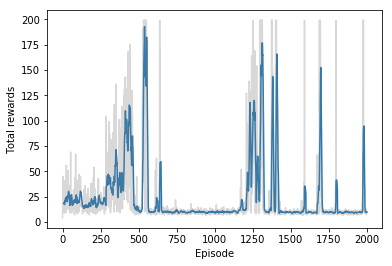

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

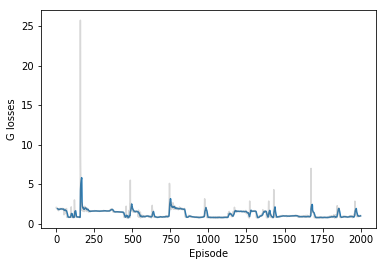

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

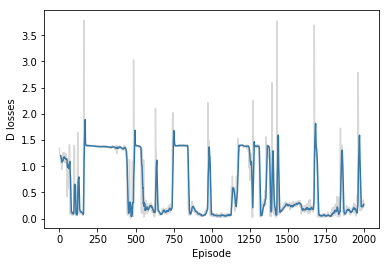

In [25]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.